# Testbeam - Checking for Missing HCAL Detectors
<b>Author:</b> Cooper Froemming
<br><b>Date:</b> May 19th, 2022
<br><b>Description:</b> This document aims to determine what which detectors are missing from the pedestal calibration files used in the CERN CMS Testbeam on April, 2022

## Imports / Initializations:

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# Keeps track of file information
class File: 
    def __init__(self, path, name, treePath):
        self.path = path
        self.name = name
        if treePath == 'default' :
            self.treePath = ':ntuplizehgcroc/hgcroc'
        else :
            self.treePath = treePath
    def setTreePath(localTPath):
        treePath = localTPath

In [ ]:
folderPath = './'

#All of the different pedestal files.
ped0415 = File(folderPath,'pedestals_20220415.csv','default')
ped0416 = File(folderPath,'pedestals_20220416.csv','default')
ped0417 = File(folderPath,'pedestals_20220417.csv','default')
ped0419 = File(folderPath,'pedestals_20220419.csv','default')
ped0421 = File(folderPath,'pedestals_20220421.csv','default')
ped0422 = File(folderPath,'pedestals_20220422.csv','default')
ped0423 = File(folderPath,'pedestals_20220423.csv','default')
ped0424_07 = File(folderPath,'pedestals_20220424_07.csv','default')
ped0424_22 = File(folderPath,'pedestals_20220424_22.csv','default')
ped0426 = File(folderPath,'pedestals_20220426.csv','default')

fileArray = [ped0415, ped0416, ped0417, ped0419, ped0421, ped0422, ped0423, ped0424_07, ped0424_22, ped0426]
fileNameArray = [ped0415.name, ped0416.name, ped0417.name, ped0419.name, ped0421.name, 
ped0422.name, ped0423.name, ped0424_07.name, ped0424_22.name, ped0426.name]

In [92]:
master = pd.read_csv(f'{ped0426.path}{ped0426.name}',comment='#',index_col=0)
detID_index = pd.Index(master.index)

## Checking for Missing Channels:
This effectively finds all of the missing channels.
<br><br><i> FIXME: Write a better description</i>

In [467]:
#      Functions
# ===================

# Adds _full to a the name of a .csv file. Returns a string.
def addNewPedestalName(name):
        full_ped_name = str(name)
        full_ped_name = full_ped_name.split('.')
        full_ped_name = str(full_ped_name[0])
        return full_ped_name+'_full.csv'

# From a .csv file, returns a dataframe with NaN filled in for missing channels.
def completePedestalFile(pedestal):
    output = pd.read_csv(f'{pedestal.path}{pedestal.name}',comment='#',
    index_col=0,names=['PEDESTAL_ADC','PEDESTAL_RMS_ADC'],skiprows=3)
    #print('Checking ',pedestal.name,'...',sep='')
    if output.size % 384 != 0:
        output = output.reindex(detID_index)
    return output

def findMean(file):
    if isinstance(file,File):
        df = pd.read_csv(f'{file.path}{file.name}',comment='#',index_col=0)
    else:
        df = file
    mask = df.loc[:,'PEDESTAL_RMS_ADC']
    mask = mask.where(mask < 10)
    df = pd.concat([df['PEDESTAL_ADC'],mask],axis=1)
    return [df['PEDESTAL_ADC'].mean(),df['PEDESTAL_RMS_ADC'].mean()]

# Finds difference as a fraction of "first" and "second" files for every value. Outputs NaN if either are missing a value.
# Returns a 2 element array with PEDESTAL_ADC and PEDESTAL_RMS_ADC differences respectively.
def findFracDiff(first,second):
    file1 = pd.read_csv(f'{first.path}{first.name}',comment='#',index_col=0)
    file2 = pd.read_csv(f'{second.path}{second.name}',comment='#',index_col=0)
    ADCDiff =1 - (file1['PEDESTAL_ADC'] - file2['PEDESTAL_ADC']) / file1['PEDESTAL_ADC']
    RMSDiff =1 - (file1['PEDESTAL_RMS_ADC'] - file2['PEDESTAL_RMS_ADC']) / file1['PEDESTAL_RMS_ADC']
    output = pd.concat([ADCDiff,RMSDiff],axis=1)
    return output
    
def replaceData(pedArray):
    print('Replacing Data...')
    output = []
    for file1 in pedArray:
        if file1 == pedArray[0]:
            print('File:',file1.name,)
            file1_df = pd.read_csv(f'{file1.path}{file1.name}',comment='#',index_col=0)
            for i in range(1,len(pedArray)):
                file2 = pedArray[i]
                file2_df = pd.read_csv(f'{pedArray[i].path}{pedArray[i].name}',comment='#',index_col=0)
                print('   Using...',file2.name,'...')
                diff = findMean(findFracDiff(file1,file2))
                result = file1_df.mask((file1_df.isna()) & ((file1_df.isna()) ^ (file2_df.isna())),file2_df.mul(diff,axis=1))
        else:
            print('File:',file1.name)
            file1_df = pd.read_csv(f'{file1.path}{file1.name}',comment='#',index_col=0)
            file2 = pedArray[0]
            file2_df = output[0][1]
            print('   Using...',file2.name,'...')
            diff = findMean(findFracDiff(file1,file2))
            result = file1_df.mask((file1_df.isna()) & ((file1_df.isna()) ^ (file2_df.isna())),file2_df.mul(diff,axis=1))
        output.append([file1.name,result])
    print('Done!')
    print()
    return output


In [403]:
missingDet = pd.DataFrame(index=detID_index, columns=['PEDESTAL_ADC','PEDESTAL_RMS_ADC'])
missingDet = ~missingDet.isna()
missingHist = pd.DataFrame(index=detID_index, columns=['PEDESTAL_ADC','PEDESTAL_RMS_ADC'],dtype=np.int64)
missingHist[:] = 0
missingPlt = pd.DataFrame(index=detID_index,dtype=np.int64)
missingPlt[:] = 0
fullPedestal = pd.DataFrame(index=detID_index, columns=['PEDESTAL_ADC','PEDESTAL_RMS_ADC'])

# Note: Skipping ped0422 because it does not follow the same naming conventions in the csv file as the others
# Note: Should also skip ped0416, as the first half is identical to ped0415
# 15, 16, and 17; 19 and 21; 23 and 24_07.
count = 0
for x in fileArray:
    if (count > 5) | (count < 5):
        currentFile = completePedestalFile(x)
        fullPedestal = currentFile
        newName = addNewPedestalName(x.name)
        fullPedestal.to_csv(path_or_buf=f'./{newName}',index_label='DetID',)
        currentFile = currentFile.isna()
        toAdd = currentFile['PEDESTAL_ADC']*1
        toAdd = toAdd.rename(x.name)
        toAdd.squeeze()
        missingHist = missingHist.add(currentFile['PEDESTAL_ADC']*1,axis=0)
        missingPlt = missingPlt.join(toAdd,how='left')
        missingDet = (missingDet | currentFile)

    count = count + 1

In [404]:
ped0415_f = File(folderPath,'pedestals_20220415_full.csv','default')
ped0416_f = File(folderPath,'pedestals_20220416_full.csv','default')
ped0417_f = File(folderPath,'pedestals_20220417_full.csv','default')
ped0419_f = File(folderPath,'pedestals_20220419_full.csv','default')
ped0421_f = File(folderPath,'pedestals_20220421_full.csv','default')
ped0422_f = File(folderPath,'pedestals_20220422_full.csv','default')
ped0423_f = File(folderPath,'pedestals_20220423_full.csv','default')
ped0424_07_f = File(folderPath,'pedestals_20220424_07_full.csv','default')
ped0424_22_f = File(folderPath,'pedestals_20220424_22_full.csv','default')
ped0426_f = File(folderPath,'pedestals_20220426_full.csv','default')

In [473]:
sect1 = replaceData([ped0415_f,ped0417_f,ped0426_f])
sect2 = replaceData([ped0419_f,ped0421_f,ped0426_f])
sect3 = replaceData([ped0423_f,ped0424_07_f,ped0426_f])
allPeds = [sect1[0],sect1[1],sect2[0],sect2[1],sect3[0],sect3[1],sect3[2]]
for ped in range(0,len(allPeds)):
    allPeds[ped][1].to_csv(path_or_buf=f'./{allPeds[ped][0]}',float_format='%.3f')


Replacing Data...
File: pedestals_20220415_full.csv


FileNotFoundError: [Errno 2] No such file or directory: './pedestals_20220415_full.csv'

### Visual Representation of Missing Channels
<i>FIXME: write a description. </i>

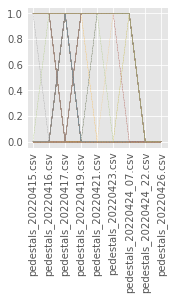

In [474]:
plt.style.use('ggplot')
fig1,plot1 = plt.subplots()
X = missingPlt.columns
Y = missingPlt.iloc[0]

for det in missingPlt.index:
    Y = missingPlt.loc[det]
    plot1.plot(X,Y,label=det,linestyle='-.',linewidth=0.25)
for tick in plot1.get_xticklabels():
    tick.set_rotation(90)
fig1.align_labels()

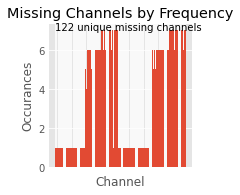

In [475]:
missingDet[(missingDet['PEDESTAL_ADC'] == True)]
output = missingHist[(missingHist['PEDESTAL_ADC'] != 0)]

fig = plt.figure()
HB = fig.add_axes([0,0,1,1])
HB.bar(x=output.index,height=output['PEDESTAL_ADC'],tick_label='')
HB.set_title('Missing Channels by Frequency')
HB.set_ylabel('Occurances')
HB.set_xlabel('Channel')
numCh = missingDet[(missingDet['PEDESTAL_ADC'] == True)].shape
HB.annotate(f'{numCh[0]} unique missing channels',(0,7))
plt.show()


### Garbage Can:
This is for personal reference of some commands that I found useful, but is not currently used. These probably aren't useful to you.

In [476]:
# Renaming Column Labels
# data = initialFile.reindex(detID_index)
# data = data.rename(columns={'PEDESTAL_ADC':'ADC','PEDESTAL_RMS_ADC':'RMS'})
# newData = newFile.reindex(detID_index)
# newData = newData.rename(columns={'PEDESTAL_ADC':'ADC','PEDESTAL_RMS_ADC':'RMS'})


# Boolean testing
# data1 = data.isna()
# data2 = newData.isna()
# data3 = (data1 | data2)
# dataLast = newData.loc[(data3.ADC == True)]
# dataLast.shape
# data1.loc['0x18881107']
# data2.loc['0x18881107']


# Number of channels test
# test = newData.iloc[380,1]
# count = 0
#
# for x in range(0,384):
#     val = newData.iloc[x,0]
#     if np.isnan(val):
#         count = count + 1
# print('Number of Missing Channels:',count)